In [1]:
!pip install rpy2 pandas numpy matplotlib seaborn geopandas statsmodels

In [2]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy import stats
import seaborn as sns
import numpy as np
import os
from rpy2.robjects import r, globalenv, numpy2ri
from matplotlib.patches import Rectangle

# For table 1
!pip install stargazer
from stargazer.stargazer import Stargazer


# Load data
data_st = pd.read_stata("Data/climate_conflict.dta")
data_df = pd.read_csv("Data/clim_conflict_for_R.csv", encoding='latin-1')
ssa_df = pd.read_csv("Data/gseasSSA.csv")
area_df = pd.read_csv("Data/croparea_weight.csv", encoding='latin-1', keep_default_na=False)
cltol_df = pd.read_csv("Data/precip_climatology.csv", index_col=0)
mss_country_df = pd.read_csv("Data/mss_countries_new.csv")

## Part 1: Regression Models & Generate Table 1

In [3]:
# Fit Model 1

# Subset data
data_cleaned = data_st.dropna(subset=['temp_all', 'temp_all_lag'])

# Define dependent variable
y = data_cleaned['war_prio_new']

# Define independent variables & fixed effects
fixed_effects = [col for col in data_cleaned.columns if col.startswith('iccode') or col.startswith('Iccyear')]
X = data_cleaned[['temp_all', 'temp_all_lag'] + fixed_effects]

# Add the constant
X = sm.add_constant(X)

# Fit the model
model = sm.OLS(y, X)
results = model.fit(cov_type='cluster', cov_kwds={'groups': data_cleaned['ccode']})

# Print the summary
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:           war_prio_new   R-squared:                       0.657
Model:                            OLS   Adj. R-squared:                  0.622
Method:                 Least Squares   F-statistic:                     34.68
Date:                Fri, 02 May 2025   Prob (F-statistic):           1.84e-09
Time:                        09:38:05   Log-Likelihood:                 246.53
No. Observations:                 889   AIC:                            -325.1
Df Residuals:                     805   BIC:                             77.32
Df Model:                          83                                         
Covariance Type:              cluster                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -1.1099      0.769     -1.443   

/srv/conda/lib/python3.11/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 84, but rank is 2
  warnings.warn('covariance of constraints does not have full '


In [4]:
# Fit Model 2

# Subset data
data_cleaned2 = data_st.dropna(subset=['temp_all', 'temp_all_lag', 'prec_all', 'prec_all_lag', 'ccode'])

# Define dependent variable
y2 = data_cleaned2['war_prio_new']

# Define independent variables & fixed effects
fixed_effects2 = [col for col in data_cleaned2.columns if col.startswith('iccode') or col.startswith('Iccyear')]
X2 = data_cleaned2[['temp_all', 'temp_all_lag', 'prec_all', 'prec_all_lag'] + fixed_effects2]

# Add the constant
X2 = sm.add_constant(X2)

# Fit the model
model2 = sm.OLS(y2, X2)
results2 = model2.fit(cov_type='cluster', cov_kwds={'groups': data_cleaned2['ccode']})

# Print the summary
print(results2.summary())

                            OLS Regression Results                            
Dep. Variable:           war_prio_new   R-squared:                       0.657
Model:                            OLS   Adj. R-squared:                  0.621
Method:                 Least Squares   F-statistic:                     19.46
Date:                Fri, 02 May 2025   Prob (F-statistic):           5.87e-09
Time:                        09:38:09   Log-Likelihood:                 246.70
No. Observations:                 889   AIC:                            -321.4
Df Residuals:                     803   BIC:                             90.55
Df Model:                          85                                         
Covariance Type:              cluster                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -1.1771      0.772     -1.525   

/srv/conda/lib/python3.11/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 86, but rank is 4
  warnings.warn('covariance of constraints does not have full '


In [5]:
# Fit Model 3

# Subset data
data_cleaned3 = data_st.dropna(subset=['temp_all', 'temp_all_lag', 'prec_all',
                                    'prec_all_lag', 'gdp_l', 'polity2_lag',
                                    'year', 'ccode'])
# Define dependent variable
y3 = data_cleaned3['war_prio_new']

# Define independent variables & fixed effects
fixed_effects3 = [col for col in data_cleaned3.columns if col.startswith('iccode')]
X3 = data_cleaned3[['temp_all', 'temp_all_lag', 'prec_all', 'prec_all_lag', 'gdp_l', 'polity2_lag', 'year'] + fixed_effects3]

# Add the constant
X3 = sm.add_constant(X3)

# Fit the model
model3 = sm.OLS(y3, X3)
results3 = model3.fit()

# Print the summary
print(results3.summary())

                            OLS Regression Results                            
Dep. Variable:           war_prio_new   R-squared:                       0.389
Model:                            OLS   Adj. R-squared:                  0.354
Method:                 Least Squares   F-statistic:                     11.12
Date:                Fri, 02 May 2025   Prob (F-statistic):           9.81e-57
Time:                        09:38:13   Log-Likelihood:                 27.536
No. Observations:                 815   AIC:                             34.93
Df Residuals:                     770   BIC:                             246.6
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -1.5215      0.983     -1.547   

In [6]:
# Define variables to keep 
keep_vars = ['temp_all','temp_all_lag', 'prec_all',
            'prec_all_lag', 'gdp_l', 'polity2_lag', 'const']

# Pass the fitted models into Stargazer
stargazer_tab = Stargazer([results, results2, results3])

# Use covariate_order to restrict which variables get displayed
stargazer_tab.covariate_order(keep_vars)

# Rename covariates
stargazer_tab.rename_covariates({"temp_all":"Temperature",
                                "temp_all_lag":"Temperature lagged 1 year",
                                "prec_all":"Precipitation",
                                "prec_all_lag":"Precipitation lagged 1 year",
                                "gdp_l":"Per capita income lagged 1 year",
                                "polity2_lag":"Political regime type lagged 1 year",
                                "const":"Constant"})


# Renaming model columns & title 
stargazer_tab.custom_columns(["Model", "Model", "Model"], [1, 1, 1])
stargazer_tab.title("Table 1. Regression coefficients on climate variables, with civil war as a dependent variable")

# Display table
print(stargazer_tab)

# Save table as HTML
with open('regression_table.html', 'w') as f:
    f.write(stargazer_tab.render_html())

## Part 2: Bootstrapping the data

In [7]:
# Ensure all non-cereals get region of their country
for i, row in area_df.iterrows():
    if row['item'] != "Cereals,Total +":
        country = row['countries']
        # find that country's region from its Cereals,Total + entry
        region_val = area_df[(area_df['countries']==country) & (area_df['item']=="Cereals,Total +")]['region']
        if len(region_val) > 0:
            area_df.at[i, 'region'] = region_val.values[0]
# Compute total land area by region (item == "land area")
land_area_by_region = {j: 0.0 for j in range(1,6)}
for i, row in area_df.iterrows():
    if row['item'] == "land area":
        reg = row['region']
        if reg != '' and not pd.isna(reg):
            land_area_by_region[int(reg)] += float(row['2000'])
# Normalize to get weights
total_land = sum(land_area_by_region.values())
unweight = np.array([land_area_by_region[j]/total_land for j in range(1,6)])

In [8]:
# Prepare country -> region mapping using area_df (from cereals entries)
country_region = {}
for i, row in area_df.iterrows():
    if row['item'] == "Cereals,Total +":
        country_region[row['countries']] = int(row['region'])

# Activate automatic R → numpy conversion
numpy2ri.activate()

# 1) Load the RData file
print("Loading RData_deltas2030monthly.Rdata…")
r['load']('Data/RData_deltas2030monthly.Rdata')
altogether = np.array(globalenv['altogether.monthly'])
print(f"  altogether.monthly shape: {altogether.shape}\n")

# 2) Decide how many model draws to use
models_total = altogether.shape[-1]
models_count = min(20, models_total)
print(f"Using models_count = {models_count} (out of {models_total})\n")

# 3) Initialize clim array
clim = np.zeros((6, 3, 2, models_count))

# 4a) Temperature: monthly ΔT → mean over 12 months
print("Computing temperature projections:")
for region_idx in range(5):
    for scen_idx in range(3):
        print(f"  Region {region_idx+1}, Scenario {scen_idx+1} → ", end="")
        temp_monthly = altogether[region_idx + 3, :, scen_idx, 0, :models_count]
        mean_arr = np.nanmean(temp_monthly, axis=0)
        # detect any all-NaN columns
        nan_cols = np.isnan(mean_arr)
        if nan_cols.any():
            print(f"found {nan_cols.sum()} all-NaN model(s), filling with 0.0; ", end="")
            mean_arr = np.nan_to_num(mean_arr, nan=0.0)
        print(f"arr.shape={temp_monthly.shape}, mean_arr[:5]={mean_arr[:5]}")
        clim[region_idx, scen_idx, 0, :] = mean_arr

# 4b) Precipitation: apply percent changes to baseline then sum
print("\nComputing precipitation projections:")
cltol = cltol_df.values  # shape (5 regions × 12 months)
for region_idx in range(5):
    clim_sum = cltol[region_idx].sum()
    for scen_idx in range(3):
        print(f"  Region {region_idx+1}, Scenario {scen_idx+1} → climatology sum = {clim_sum}")
        for m in range(models_count):
            raw = altogether[region_idx + 3, :, scen_idx, 1, m]
            with np.errstate(invalid='ignore'):
                pct_mult = np.nan_to_num(raw/100.0 + 1.0, nan=1.0)
            if clim_sum > 0:
                clim_val = ((cltol[region_idx] * pct_mult).sum()/clim_sum - 1.0)*100.0
            else:
                clim_val = 0.0
            clim[region_idx, scen_idx, 1, m] = clim_val
            if m < 2:
                print(f"    Model {m+1} raw[:3]={raw[:3]}, mult[:3]={pct_mult[:3]}, out={clim_val:.2f}")
        print(f"    first-3 precip-changes = {clim[region_idx, scen_idx, 1, :3]}\n")

# 4c) All-SSA unweighted composite
print("Computing All-SSA unweighted composite:")
for scen_idx in range(3):
    for var_idx in range(2):
        vals = unweight @ clim[:5, scen_idx, var_idx, :]
        clim[5, scen_idx, var_idx, :] = vals
    print(f"  Scenario {scen_idx+1} first-3 temp={clim[5, scen_idx, 0, :3]}, precip={clim[5, scen_idx, 1, :3]}")

print("\nDone. clim.shape →", clim.shape)

Loading RData_deltas2030monthly.Rdata…
  altogether.monthly shape: (13, 12, 3, 2, 28)

Using models_count = 20 (out of 28)

Computing temperature projections:
  Region 1, Scenario 1 → found 2 all-NaN model(s), filling with 0.0; arr.shape=(12, 20), mean_arr[:5]=[0.         1.56854251 1.24153791 1.43459786 0.58929374]
  Region 1, Scenario 2 → found 5 all-NaN model(s), filling with 0.0; arr.shape=(12, 20), mean_arr[:5]=[0.88938764 0.         1.15328756 1.16362332 1.09427059]
  Region 1, Scenario 3 → found 2 all-NaN model(s), filling with 0.0; arr.shape=(12, 20), mean_arr[:5]=[0.69274264 1.35612116 0.98033549 1.04500682 0.46142065]
  Region 2, Scenario 1 → found 2 all-NaN model(s), filling with 0.0; arr.shape=(12, 20), mean_arr[:5]=[0.         1.39561376 1.16433619 1.16633758 0.65966305]
  Region 2, Scenario 2 → found 5 all-NaN model(s), filling with 0.0; arr.shape=(12, 20), mean_arr[:5]=[0.80739214 0.         1.04742762 1.08491854 0.95730448]
  Region 2, Scenario 3 → found 2 all-NaN model

/tmp/ipykernel_614/3514902241.py:30: RuntimeWarning: Mean of empty slice
  mean_arr = np.nanmean(temp_monthly, axis=0)


In [9]:
# Generate projections of income and regime change to 2030
# 1) Pivot GDP so each country has a 1981 and 2002 value side by side
gdp = data_df[['country','year_actual','gdp_l']].copy()
gdp_wide = gdp.pivot(index='country', columns='year_actual', values='gdp_l')

# 2) Keep only countries with non‐missing, positive GDP in both years
gdp_wide = gdp_wide[[1981, 2002]].dropna()
gdp_wide = gdp_wide[(gdp_wide[1981] > 0) & (gdp_wide[2002] > 0)]

# 3) Compute annual growth rates
years = 2002 - 1981
ygro = np.exp(np.log(gdp_wide[2002] / gdp_wide[1981]) / years)

# 4) Median end‐GDP
median_gdp_end = gdp_wide[2002].median()

# 5) Projected income changes by 2030
#   - (1) 2% p.a. “optimistic” scenario
#   - (2) continuation of median historical growth
inc_opt = median_gdp_end * (1.02 ** 27) - median_gdp_end
inc_hist= median_gdp_end * (ygro.median() ** 27) - median_gdp_end

incchg = [inc_opt, inc_hist]
# Compute polchg: average projected polity change by 2030
pol_start = data_df.drop_duplicates('country').set_index('country')['polity1980']
pol_end = data_df[data_df['year_actual']==2002].set_index('country')['polity2']
common_pol_c = pol_start.index.intersection(pol_end.index)
pol_start = pol_start.loc[common_pol_c].fillna(0)
pol_end = pol_end.loc[common_pol_c].fillna(0)
pol_diff = pol_end - pol_start
med_pol_change = np.median(pol_diff)
pol2030 = pol_end + med_pol_change
pol2030 = pol2030.clip(upper=10)  # cap at 10
polchg = float((pol2030 - pol_end).mean())

print(incchg)
print(polchg)

[np.float64(757.0952093039703), np.float64(44.06841978941088)]
5.825


In [10]:
# Prepare design matrices for regression models and perform bootstrap
print("Starting regression matrix preparation and bootstrap...")

# Define columns for each regression model (based on R script hold list)
hold_cols_R = {
    1: [106, 42, 45] + list(range(110, 151)) + list(range(178, 219)),
    2: [106, 42, 45, 54, 57] + list(range(110, 151)) + list(range(178, 219)),
    3: [106, 42, 45, 10, 228] + list(range(110, 151)) + [177],
    4: [106, 42, 45, 54, 57, 10, 228] + list(range(110, 151)) + [177],
    5: [106, 42, 45, 54, 57] + list(range(110, 151)) + [177],
    6: [106, 48, 51, 60, 63] + list(range(110, 151)) + list(range(178, 219)),
    7: [106] + list(range(219, 223)) + list(range(110, 151)) + list(range(178, 219)),
    8: [106, 42, 45, 11, 12] + list(range(110, 151)) + list(range(178, 219)),
    9: [106, 70, 77, 71, 78] + list(range(110, 151)) + list(range(178, 219))
}
# Convert R (1-indexed) to Python (0-indexed)
hold_cols = {i: [c-1 for c in cols] for i, cols in hold_cols_R.items()}

# Build X, Y for each model, dropping rows with NA in any predictor
holds_data = {}
for i, cols in hold_cols.items():
    print(f"\nProcessing model {i}")
    Y_col = cols[0]
    X_cols = cols[1:]
    df_sub = data_df.iloc[:, [Y_col] + X_cols].dropna()
    print(f" - Columns used: Y={Y_col}, X={len(X_cols)} columns")
    print(f" - Rows after dropping NA: {len(df_sub)}")
    Y = df_sub.iloc[:, 0].astype(float).values
    X = df_sub.iloc[:, 1:].astype(float).values
    # Add intercept column
    X = np.column_stack([np.ones(X.shape[0]), X])
    holds_data[i] = (X, Y)

# Bootstrap linear regressions
print("\nBeginning bootstrap regressions...")
np.random.seed(0)
B = 10000
boot_coefs = {}
for i in range(1, 10):
    X, Y = holds_data[i]
    N = X.shape[0]
    print(f" - Bootstrapping model {i} with {N} rows and {X.shape[1]} predictors (incl. intercept)")
    coefs = np.empty((B, 6))  # store only first 6 coefficients after intercept
    for b in range(B):
        idx = np.random.randint(0, N, size=N)
        Xb = X[idx]
        Yb = Y[idx]
        coef = np.linalg.lstsq(Xb, Yb, rcond=None)[0]
        coefs[b, :] = coef[1:7]
        if b % 2000 == 0:
            print(f"   > Model {i}: Completed {b} bootstraps...")
    boot_coefs[i] = coefs

print("\nBootstrap complete.")

Starting regression matrix preparation and bootstrap...

Processing model 1
 - Columns used: Y=105, X=84 columns
 - Rows after dropping NA: 889

Processing model 2
 - Columns used: Y=105, X=86 columns
 - Rows after dropping NA: 889

Processing model 3
 - Columns used: Y=105, X=46 columns
 - Rows after dropping NA: 815

Processing model 4
 - Columns used: Y=105, X=48 columns
 - Rows after dropping NA: 815

Processing model 5
 - Columns used: Y=105, X=46 columns
 - Rows after dropping NA: 889

Processing model 6
 - Columns used: Y=105, X=86 columns
 - Rows after dropping NA: 889

Processing model 7
 - Columns used: Y=105, X=86 columns
 - Rows after dropping NA: 889

Processing model 8
 - Columns used: Y=105, X=86 columns
 - Rows after dropping NA: 889

Processing model 9
 - Columns used: Y=105, X=86 columns
 - Rows after dropping NA: 809

Beginning bootstrap regressions...
 - Bootstrapping model 1 with 889 rows and 85 predictors (incl. intercept)
   > Model 1: Completed 0 bootstraps...
 

In [11]:
# Create a folder to store the output if needed
os.makedirs("bootstrap_outputs", exist_ok=True)

# Save each model's coefficients to a CSV
for i in range(1, 10):
    df = pd.DataFrame(boot_coefs[i], columns=[f"coef_{j+1}" for j in range(6)])
    filename = f"bootstrap_outputs/bootstrap_{i}.csv"
    df.to_csv(filename, index=False)
    print(f"Saved model {i} coefficients to {filename}")

Saved model 1 coefficients to bootstrap_outputs/bootstrap_1.csv
Saved model 2 coefficients to bootstrap_outputs/bootstrap_2.csv
Saved model 3 coefficients to bootstrap_outputs/bootstrap_3.csv
Saved model 4 coefficients to bootstrap_outputs/bootstrap_4.csv
Saved model 5 coefficients to bootstrap_outputs/bootstrap_5.csv
Saved model 6 coefficients to bootstrap_outputs/bootstrap_6.csv
Saved model 7 coefficients to bootstrap_outputs/bootstrap_7.csv
Saved model 8 coefficients to bootstrap_outputs/bootstrap_8.csv
Saved model 9 coefficients to bootstrap_outputs/bootstrap_9.csv


## Part 3: Generate Figure 1

ERROR 1: PROJ: proj_create_from_database: Open of /srv/conda/share/proj failed


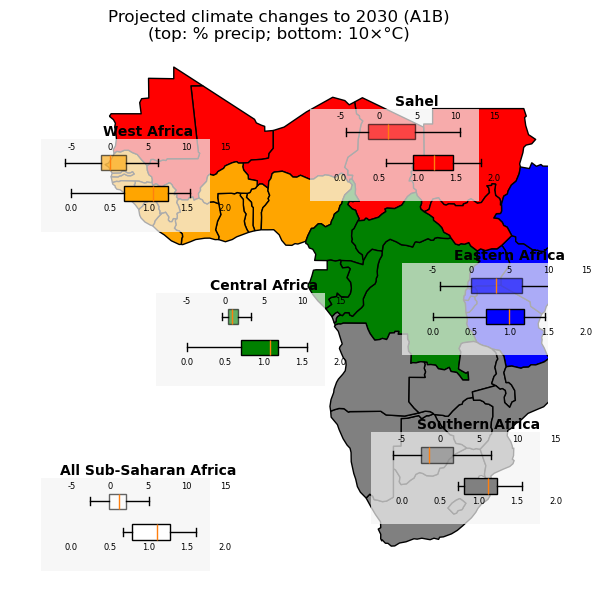

In [12]:
# 1) Load & prepare the Africa map
world = gpd.read_file("Map file/ne_110m_admin_0_countries.zip")
world = world.rename(columns={"ADMIN": "name"})
africa = world[world["CONTINENT"] == "Africa"].copy()

# 2) SSA country list and manual region assignment
ssa_names = list(ssa_df.iloc[np.r_[0:10, 11:42], 1].astype(str))
ssa_names[11] = "Gambia"

# Regions from R's 'countrycols'
countrycols = [
    5,5,2,4,1,3,3,3,3,4,
    4,2,3,2,2,2,4,2,5,5,
    5,1,1,5,1,2,2,4,5,2,
    2,4,1,2,4,4,2,5,5,5,5
]

# Map SSA names to the shapefile 'name' values
name_map = {
    "Gambia": "Gambia",
    "Ivory Coast":  "Côte d'Ivoire",
    "Congo":        "Republic of the Congo",
    "Zaire":        "Democratic Republic of the Congo",
    "Tanzania":     "United Republic of Tanzania",
    "South Sudan":  "South Sudan"
}

# Build a DataFrame of country→region
region_list = []
for ssa_name, reg in zip(ssa_names, countrycols):
    shp_name = name_map.get(ssa_name, ssa_name)
    region_list.append({"name": shp_name, "region": reg})
region_df = pd.DataFrame(region_list)

# Add Ivory Coast and South Sudan explicitly
extra = pd.DataFrame([
    {"name": "Ivory Coast", "region": 2},
    {"name": "South Sudan",    "region": 1}
])
region_df = pd.concat([region_df, extra], ignore_index=True)

# 3) Merge onto the Africa GeoDataFrame
afr_countries = africa.merge(region_df, on="name", how="inner")

# 4) Plot
locx = {1:10, 2:-25, 3:-10, 4:22, 5:18}
locy = {1:12, 2:8,   3:-12, 4:-8,  5:-30}
region_names = {
    1:"Sahel", 2:"West Africa", 3:"Central Africa",
    4:"Eastern Africa", 5:"Southern Africa"
}
colors = {1:"red", 2:"orange", 3:"green", 4:"blue", 5:"grey"}

fig, ax = plt.subplots(figsize=(7,7), subplot_kw={"aspect":"equal"})

# Plot SSA countries colored by region:
afr_countries["color"] = afr_countries["region"].map(colors)
afr_countries.plot(ax=ax, color=afr_countries["color"], edgecolor="black")

# Map styling
ax.set_xlim(-30,40)
ax.set_ylim(-40,30)
ax.axis("off")
ax.set_title("Projected climate changes to 2030 (A1B)\n(top: % precip; bottom: 10×°C)")

# Draw inset boxplots with smaller boxes
box_width = 2    # narrower boxes
bg_w, bg_h = 22, 12  # smaller inset backgrounds

for i in range(1,6):
    x0, y0 = locx[i], locy[i]

    # inset background
    ax.add_patch(Rectangle((x0-1, y0-2), bg_w, bg_h,
                           facecolor="whitesmoke", alpha=0.7, zorder=1))

    # climate data
    temp = clim[i-1,0,0,:] * 10    # deci‐°C
    prec = clim[i-1,0,1,:]        # %

    # temperature box (shift right +3)
    ax.boxplot(
        temp + x0 + 3, positions=[y0+3], widths=[box_width], vert=False,
        patch_artist=True,
        boxprops=dict(facecolor=colors[i], edgecolor="black"),
        whiskerprops=dict(color="black"), capprops=dict(color="black"),
        showfliers=False, zorder=2
    )

    # precipitation box (shift right +8)
    ax.boxplot(
        prec + x0 + 8, positions=[y0+7], widths=[box_width], vert=False,
        patch_artist=True,
        boxprops=dict(facecolor=colors[i], edgecolor="black", alpha=0.6),
        whiskerprops=dict(color="black"), capprops=dict(color="black"),
        showfliers=False, zorder=2
    )

    # axis ticks & labels
    setzero = 8
    xs = np.arange(x0+(setzero-5), x0+20+(setzero-5)+1, 5)
    # bottom (temp) axis labels
    for j, lab in enumerate(np.arange(0,2.5,0.5)):
        ax.text(xs[j], y0+0.5, f"{lab:.1f}", ha="center", va="bottom", fontsize=6, zorder=3)
    # top (precip) axis labels
    for j, lab in enumerate(np.arange(-5,20,5)):
        ax.text(xs[j], y0+8.5, f"{int(lab)}", ha="center", va="bottom", fontsize=6, zorder=3)

    # region label
    ax.text(x0+setzero+5, y0+bg_h-1, region_names[i],
            ha="center", va="center", fontweight="bold", zorder=3)

# All SSA
x0, y0 = -25, -36  # bottom-left corner
ax.add_patch(Rectangle((x0-1, y0-2), bg_w, bg_h,
                       facecolor="whitesmoke", alpha=0.7, zorder=1))

temp = clim[5,0,0,:] * 10    # deci‐°C
prec = clim[5,0,1,:]         # %

# temperature box
ax.boxplot(
    temp + x0 + 3, positions=[y0+3], widths=[box_width], vert=False,
    patch_artist=True,
    boxprops=dict(facecolor="white", edgecolor="black"),
    whiskerprops=dict(color="black"), capprops=dict(color="black"),
    showfliers=False, zorder=2
)

# precipitation box
ax.boxplot(
    prec + x0 + 8, positions=[y0+7], widths=[box_width], vert=False,
    patch_artist=True,
    boxprops=dict(facecolor="white", edgecolor="black", alpha=0.6),
    whiskerprops=dict(color="black"), capprops=dict(color="black"),
    showfliers=False, zorder=2
)

# axis ticks & labels
setzero = 8
xs = np.arange(x0+(setzero-5), x0+20+(setzero-5)+1, 5)
# bottom (temp) axis labels
for j, lab in enumerate(np.arange(0,2.5,0.5)):
    ax.text(xs[j], y0+0.5, f"{lab:.1f}", ha="center", va="bottom", fontsize=6, zorder=3)
# top (precip) axis labels
for j, lab in enumerate(np.arange(-5,20,5)):
    ax.text(xs[j], y0+8.5, f"{int(lab)}", ha="center", va="bottom", fontsize=6, zorder=3)

# title label
ax.text(x0+setzero+5, y0+bg_h-1, "All Sub-Saharan Africa",
        ha="center", va="center", fontweight="bold", zorder=3)

# show plot
plt.show()

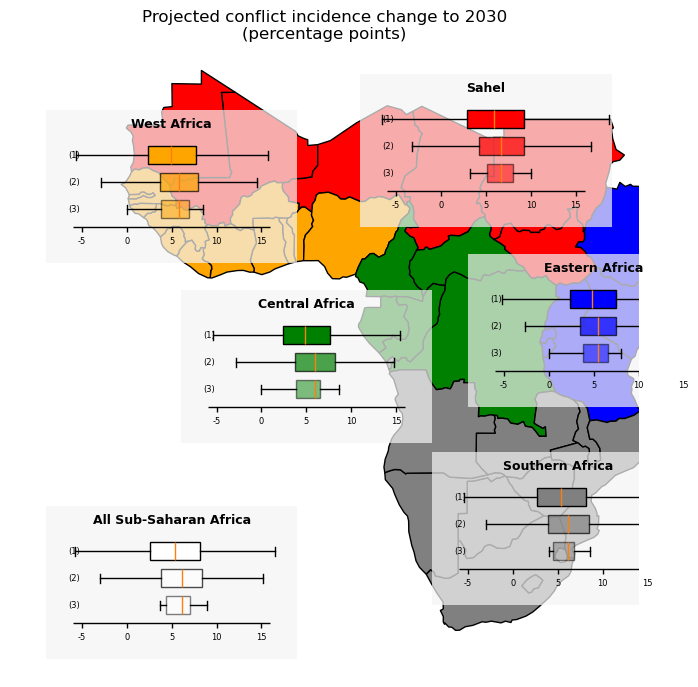

In [13]:
# Right panel only: Conflict‐incidence change map 
fig, ax = plt.subplots(figsize=(7,7), subplot_kw={"aspect":"equal"})

# 1) Draw SSA region map
afr_countries.plot(ax=ax, color=afr_countries["color"], edgecolor="black")
ax.set_xlim(-30, 40)
ax.set_ylim(-40, 30)
ax.axis("off")
ax.set_title("Projected conflict incidence change to 2030\n(percentage points)")

# 2) Get bootstrap coefficients from model 1 (temp-only)
coef1 = boot_coefs[1].copy()
coef1[:, 2:6] = 0  # zero out non-temp terms

# 3) Constants for inset layout
setzero = 8          # x offset for centering
bg_w, bg_h = 28, 17  # background box width and height
box_w = 2            # boxplot thickness

for i in range(1, 6):
    x0, y0 = locx[i], locy[i]

    # a) semi-transparent background
    ax.add_patch(Rectangle(
        (x0-1, y0-2), bg_w, bg_h,
        facecolor="whitesmoke", edgecolor="none", alpha=0.7, zorder=1
    ))

    proj_t = clim[i-1, 0, 0, :]
    base = coef1[:,0] + coef1[:,1]

    # b) (3) climate-only
    all3 = proj_t * np.median(base) * 100
    ax.boxplot(
        all3 + x0 + setzero,
        positions=[y0+4],
        widths=[box_w], vert=False,
        patch_artist=True,
        boxprops=dict(facecolor=colors[i], edgecolor="black", alpha=0.5),
        whiskerprops=dict(color="black"),
        capprops=dict(color="black"),
        showfliers=False, zorder=2
    )

    # c) (2) regression-only
    med_t = np.median(proj_t)
    all2 = med_t * base * 100
    ax.boxplot(
        all2 + x0 + setzero,
        positions=[y0+7],
        widths=[box_w], vert=False,
        patch_artist=True,
        boxprops=dict(facecolor=colors[i], edgecolor="black", alpha=0.7),
        whiskerprops=dict(color="black"),
        capprops=dict(color="black"),
        showfliers=False, zorder=2
    )

    # d) (1) combined uncertainty
    all1 = np.hstack([proj_t[j] * base for j in range(models_count)]) * 100
    ax.boxplot(
        all1 + x0 + setzero,
        positions=[y0+10],
        widths=[box_w], vert=False,
        patch_artist=True,
        boxprops=dict(facecolor=colors[i], edgecolor="black"),
        whiskerprops=dict(color="black"),
        capprops=dict(color="black"),
        showfliers=False, zorder=2
    )

    # e) axis line and ticks at y0+2
    axis_y = y0 + 2
    x_start = x0 + (setzero-5) - 1
    x_end = x0 + 20 + (setzero-5) + 1
    ax.hlines(axis_y, x_start, x_end, color="black", linewidth=1, zorder=2)
    for j, t in enumerate(np.arange(-5, 20, 5)):
        xt = t + x0 + setzero
        ax.vlines(xt, axis_y - 0.5, axis_y, color="black", linewidth=1, zorder=2)
        ax.text(xt, axis_y - 1, f"{int(t)}", ha="center", va="top", fontsize=6, zorder=3)

    # f) labels (1), (2), (3)
    ax.text(x0 + setzero - 6.5, y0+10, "(1)", fontsize=6, va="center", zorder=3)
    ax.text(x0 + setzero - 6.5, y0+7,  "(2)", fontsize=6, va="center", zorder=3)
    ax.text(x0 + setzero - 6.5, y0+4,  "(3)", fontsize=6, va="center", zorder=3)

    # g) region title
    ax.text(x0 + setzero + 5, y0 + 13.5, region_names[i],
            ha="center", va="center", fontsize=9, fontweight="bold", zorder=3)
# Add All Sub-Saharan Africa inset (region 6, index 5)
x0, y0 = -25, -36  # bottom-left corner

# a) background
ax.add_patch(Rectangle(
    (x0-1, y0-2), bg_w, bg_h,
    facecolor="whitesmoke", edgecolor="none", alpha=0.7, zorder=1
))

proj_t = clim[5, 0, 0, :]
base = coef1[:,0] + coef1[:,1]

# b) (3) climate-only
all3 = proj_t * np.median(base) * 100
ax.boxplot(
    all3 + x0 + setzero,
    positions=[y0+4],
    widths=[box_w], vert=False,
    patch_artist=True,
    boxprops=dict(facecolor="white", edgecolor="black", alpha=0.5),
    whiskerprops=dict(color="black"),
    capprops=dict(color="black"),
    showfliers=False, zorder=2
)

# c) (2) regression-only
med_t = np.median(proj_t)
all2 = med_t * base * 100
ax.boxplot(
    all2 + x0 + setzero,
    positions=[y0+7],
    widths=[box_w], vert=False,
    patch_artist=True,
    boxprops=dict(facecolor="white", edgecolor="black", alpha=0.7),
    whiskerprops=dict(color="black"),
    capprops=dict(color="black"),
    showfliers=False, zorder=2
)

# d) (1) combined uncertainty
all1 = np.hstack([proj_t[j] * base for j in range(models_count)]) * 100
ax.boxplot(
    all1 + x0 + setzero,
    positions=[y0+10],
    widths=[box_w], vert=False,
    patch_artist=True,
    boxprops=dict(facecolor="white", edgecolor="black"),
    whiskerprops=dict(color="black"),
    capprops=dict(color="black"),
    showfliers=False, zorder=2
)

# e) axis line + ticks
axis_y = y0 + 2
x_start = x0 + (setzero-5) - 1
x_end = x0 + 20 + (setzero-5) + 1
ax.hlines(axis_y, x_start, x_end, color="black", linewidth=1, zorder=2)
for j, t in enumerate(np.arange(-5, 20, 5)):
    xt = t + x0 + setzero
    ax.vlines(xt, axis_y - 0.5, axis_y, color="black", linewidth=1, zorder=2)
    ax.text(xt, axis_y - 1, f"{int(t)}", ha="center", va="top", fontsize=6, zorder=3)

# f) labels
ax.text(x0 + setzero - 6.5, y0+10, "(1)", fontsize=6, va="center", zorder=3)
ax.text(x0 + setzero - 6.5, y0+7,  "(2)", fontsize=6, va="center", zorder=3)
ax.text(x0 + setzero - 6.5, y0+4,  "(3)", fontsize=6, va="center", zorder=3)

# g) region title
ax.text(x0 + setzero + 5, y0 + 13.5, "All Sub-Saharan Africa",
        ha="center", va="center", fontsize=9, fontweight="bold", zorder=3)

# show plot 
plt.tight_layout()
plt.show()

## Part 4: Generate Table 2

In [14]:
# Table 2: Projected change in conflict risk to 2030 under climate scenarios

# 1) Baseline incidence
base_incidence = data_df.loc[data_df['year_actual'] < 2003, 'war_prio_new'].mean()
print(f"Baseline incidence = {base_incidence:.3f}")

# 2) Mean continental precip (R's data[,54] ⇒ Python idx 53)
mean_precip = data_df.loc[data_df['year_actual'] < 2003, data_df.columns[53]].mean()
print(f"Mean continental precip (data[,54]) = {mean_precip:.1f} mm\n")

# 3) Recompute reg-level climate projections exactly as R (mean with ANY NaN → NaN)
models_total = altogether.shape[-1]
models_count = min(20, models_total)
print(f"Using {models_count} climate‐model draws (of {models_total})\n")

# allocate
reg_temp = np.full((5, 3, models_count), np.nan)
reg_prec = np.full((5, 3, models_count), np.nan)
cltol = cltol_df.values  # shape (5 regions × 12 months)

for r in range(5):
    for s in range(3):
        for j in range(models_count):
            # temperature: monthly ΔT
            tm = altogether[r+3, :, s, 0, j]
            if not np.isnan(tm).any():
                reg_temp[r, s, j] = tm.mean()
            # precipitation: pct change → apply to climatology
            pm = altogether[r+3, :, s, 1, j]
            if not np.isnan(pm).any():
                pct = pm / 100.0 + 1.0
                tot = cltol[r].sum()
                reg_prec[r, s, j] = ((cltol[r] * pct).sum() / tot - 1.0) * 100.0

# composite All-SSA
# unweight is your 1×5 array of region weights
ssa_temp = np.tensordot(unweight, reg_temp, axes=([0], [0]))   # → shape (3, models_count)
ssa_prec = np.tensordot(unweight, reg_prec, axes=([0], [0]))   # → shape (3, models_count)
print("Composite climate shapes:", ssa_temp.shape, ssa_prec.shape)
print("Valid climate draws per scenario (temp):", np.sum(~np.isnan(ssa_temp), axis=1))
print("Valid climate draws per scenario (prec):", np.sum(~np.isnan(ssa_prec), axis=1), "\n")

# 4) Now build Table 2
scenarios = ["A1b", "A2", "B1"]
rows = []

for model in (1, 2):
    coeffs = boot_coefs[model].copy()  # shape (B,6)
    if model == 1:
        coeffs[:, 2:6] = 0.0   # zero out precip & controls
    else:
        coeffs[:, 4:6] = 0.0   # zero out the GDP/polity controls

    temp_beta = coeffs[:, 0] + coeffs[:, 1]  
    prec_beta = coeffs[:, 2] + coeffs[:, 3]  

    for si, scen in enumerate(scenarios):
        proj_t = ssa_temp[si, :]
        proj_p = ssa_prec[si, :] * mean_precip / 100.0

        # drop any NaNs
        valid = (~np.isnan(proj_t)) & (~np.isnan(proj_p))
        proj_t = proj_t[valid]
        proj_p = proj_p[valid]
        print(f"Model {model}, Scenario {scen}: using {proj_t.size} climate draws")

        # build the full distribution
        all_changes = np.hstack([
            proj_t[j] * temp_beta + proj_p[j] * prec_beta
            for j in range(proj_t.shape[0])
        ]) * 100.0  # to percentage-point change
        print(f"  raw all_changes size = {all_changes.size}")

        # true 5th/95th on whole dist
        low, high = np.percentile(all_changes, [5, 95])
        # then take median of only the central 90%
        central = all_changes[(all_changes >= low) & (all_changes <= high)]
        med     = np.median(central)
        pct0    = 100.0 * np.mean(all_changes < 0)

        print(f"  → low={low:.2f}, med={med:.2f}, high={high:.2f}, %<0={pct0:.1f}\n")

        rows.append({
            "Scenario": scen.upper(),
            "Model":     f"Model {model}",
            "Median % change": round(med, 1),
            "% increase relative to baseline": round(med / base_incidence, 1),
            "5th–95th percentile": f"{round(low / base_incidence,1)}–{round(high / base_incidence,1)}",
            "% obs < 0": round(pct0, 1)
        })

# 5) Assemble, save, and display
table2_df = pd.DataFrame(rows).set_index(["Scenario","Model"])
table2_df.to_csv("Table2_formatted.csv")
print("\nFinal Table 2:")
table2_df

Baseline incidence = 0.110
Mean continental precip (data[,54]) = 1.0 mm

Using 20 climate‐model draws (of 28)

Composite climate shapes: (3, 20) (3, 20)
Valid climate draws per scenario (temp): [18 15 18]
Valid climate draws per scenario (prec): [18 15 18] 

Model 1, Scenario A1b: using 18 climate draws
  raw all_changes size = 180000
  → low=0.55, med=5.86, high=13.09, %<0=3.5

Model 1, Scenario A2: using 15 climate draws
  raw all_changes size = 150000
  → low=0.49, med=5.16, high=11.17, %<0=3.5

Model 1, Scenario B1: using 18 climate draws
  raw all_changes size = 180000
  → low=0.45, med=4.73, high=10.91, %<0=3.5

Model 2, Scenario A1b: using 18 climate draws
  raw all_changes size = 180000
  → low=0.38, med=6.20, high=14.29, %<0=3.9

Model 2, Scenario A2: using 15 climate draws
  raw all_changes size = 150000
  → low=0.32, med=5.47, high=12.20, %<0=4.0

Model 2, Scenario B1: using 18 climate draws
  raw all_changes size = 180000
  → low=0.28, med=5.02, high=11.88, %<0=4.0


Final 

,,Median % change,% increase relative to baseline,5th–95th percentile,% obs < 0
Scenario,Model,,,,
A1B,Model 1,5.9,53.1,5.0–118.8,3.5
A2,Model 1,5.2,46.8,4.4–101.4,3.5
B1,Model 1,4.7,42.9,4.0–98.9,3.5
A1B,Model 2,6.2,56.2,3.4–129.6,3.9
A2,Model 2,5.5,49.6,2.9–110.7,4.0
B1,Model 2,5.0,45.6,2.6–107.8,4.0


## Part 5: Generate Figure 2

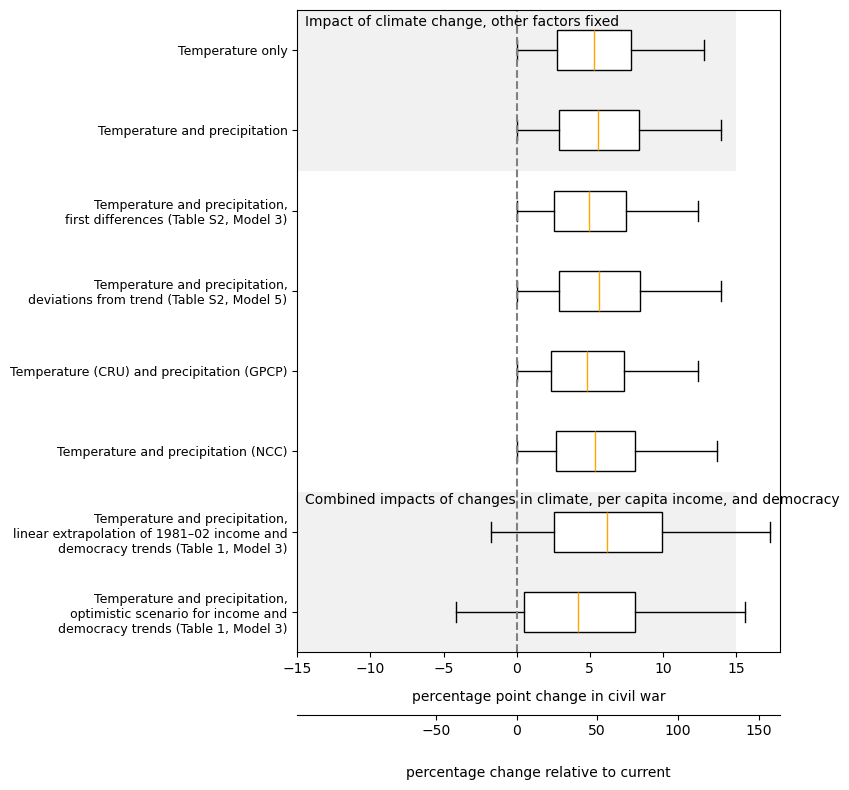

In [15]:
# Figure 2: Conflict projections under various model assumptions

# 1) Assemble R’s hold[[1]]…hold[[8]]:
hold = [
    boot_coefs[1],  # Model 1: temp only
    boot_coefs[2],  # Model 2: temp + precip
    boot_coefs[6],  # Model 6: first differences
    boot_coefs[7],  # Model 7: deviations from trend
    boot_coefs[8],  # Model 8: CRU temp & GPCP precip
    boot_coefs[9],  # Model 9: NCC data
    boot_coefs[4],  # Model 3 (linear inc/dem)
    boot_coefs[4],  # same, optimistic inc/dem
]

# 2) All‑SSA
k = 5
proj_t = clim[k, 0, 0, :]                   # ΔT under A1B
proj_p = clim[k, 0, 1, :] * mean_precip/100.0  # ΔP scaled to mean_precip

# 3) Income/regime change values
inc_hist = incchg[1]
inc_opt  = incchg[0]
polchg   = polchg

# 4) Build the 8 trimmed distributions
dists = []
for i, coef in enumerate(hold):
    coef = coef.copy()
    # zero‑out exactly as in R:
    if i == 0:
        coef[:, 2:6] = 0      # Model 1: no precip, no inc/dem
    elif 1 <= i <= 5:
        coef[:, 4:6] = 0      # Models 2–6: have temp+precip, no inc/dem
    # Models 7 & 8 keep all columns

    inc = 0.0
    if i == 6: inc = inc_hist
    if i == 7: inc = inc_opt

    # for each climate draw j, apply all B boot coefs → B values, then stack
    all_changes = np.concatenate([
        proj_t[j] * (coef[:,0] + coef[:,1])
      + proj_p[j] * (coef[:,2] + coef[:,3])
      + inc        * coef[:,4]
      + polchg     * coef[:,5]
        for j in range(proj_t.size)
    ]) * 100.0  # convert to %‐point change

    # trim to middle 90%
    lo, hi = np.percentile(all_changes, [5, 95])
    central = all_changes[(all_changes >= lo) & (all_changes <= hi)]
    dists.append(central)

# 5) Labels, reversed for bottom‑to‑top ordering
labels1 = [
    "Temperature only",
    "Temperature and precipitation",
    "Temperature and precipitation,\nfirst differences (Table S2, Model 3)",
    "Temperature and precipitation,\ndeviations from trend (Table S2, Model 5)",
    "Temperature (CRU) and precipitation (GPCP)",
    "Temperature and precipitation (NCC)",
]
labels2 = [
    "Temperature and precipitation,\nlinear extrapolation of 1981–02 income and\ndemocracy trends (Table 1, Model 3)",
    "Temperature and precipitation,\noptimistic scenario for income and\ndemocracy trends (Table 1, Model 3)",
]
labels = (labels1 + labels2)[::-1]

# 6) Plot
fig, ax = plt.subplots(figsize=(8,8))
ax.boxplot(dists[::-1], vert=False, showfliers=False,
           patch_artist=True,
           boxprops=dict(facecolor='white', edgecolor='black'),
           medianprops=dict(color='orange'),
           whiskerprops=dict(color='black'),
           capprops=dict(color='black'))

# primary axis (percentage‐point change)
ax.axvline(0, linestyle='--', color='gray')
ax.set_xlabel("percentage point change in civil war", labelpad=10)
ax.set_xlim(-15, 18)
ax.set_yticks(np.arange(1, len(labels)+1))
ax.set_yticklabels(labels, fontsize=9)

# shading for the two groups
ax.add_patch(plt.Rectangle((-15, 6.5), 30, 2, facecolor='lightgrey', alpha=0.3, transform=ax.transData))
ax.text(-14.5, 8.35, "Impact of climate change, other factors fixed", va='center', fontsize=10)
ax.add_patch(plt.Rectangle((-15, 0.5), 30, 2, facecolor='lightgrey', alpha=0.3, transform=ax.transData))
ax.text(-14.5, 2.4, "Combined impacts of changes in climate, per capita income, and democracy", va='center', fontsize=10)

# 7) secondary axis for % change relative to baseline
base_frac = base_incidence 
secax = ax.secondary_xaxis(
    'bottom',
    functions=(lambda x: x/base_frac, lambda x: x*base_frac)
)
secax.spines['bottom'].set_position(('outward', 45))
secax.set_xlabel("percentage change relative to current", labelpad=20)
secax.set_xticks([-50, 0, 50, 100, 150])

# Show figure
plt.tight_layout()
plt.show()